### Automatic Differentiation without backpropagation

In [81]:
import torch

x = torch.tensor([1.0, 2.0], requires_grad=True)
y = 2 * x

grad = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y))
print(grad) 


(tensor([2., 2.]),)


### Feynman-Kac

the Feynman-Kac theorem allows us to express the solution to the PDE as the expectation of a discounted payoff function of a stochastic process.

\\[u(x,t) = e^{-rt}\mathbb{E}_{\mathbb Q}\left[(X_T - 1)^+| X_t = x\right] \ \text{to   (PDE + Initial
condition)}\\]


### PDE method - Black-Scholes Model

\\[\frac{\partial u}{\partial t} - \frac{1}{2}\sigma^2 x^2 \frac{\partial^2 u}{\partial x^2} - rx\frac{\partial u}{\partial x}+ru=0\\]

\\[u(x,0)= (x-1)^+\\]

### Loss Function

\\[C(\theta) = \left\|\frac{\partial u}{\partial t}(x,t;\theta) - \frac{1}{2}\sigma^2 x^2 \frac{\partial^2 u}{\partial x^2}(x,t;\theta) - rx\frac{\partial u}{\partial x}(x,t;\theta)+ru(x,t;\theta)\right\|_{L^2([0,3]\times [0,1])}^2 + \left\|u(x,0;\theta) - (x-1)^+\right\|_{L^2([0,3])}^2\\]



In [68]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm

class ANN(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(ANN, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hidden = n_hidden

        # Parameters of the input layer
        self.wi = nn.Linear(n_input,n_hidden,bias=True)
        self.wi.weight = nn.Parameter(torch.randn((n_hidden,n_input)))
        
        # Parameters of the hidden layers
        self.wh0 = nn.Linear(n_hidden,n_hidden,bias=True)
        self.wh0.weight = nn.Parameter(torch.randn((n_hidden,n_hidden)))
        self.wh1 = nn.Linear(n_hidden,n_hidden,bias=True)
        self.wh1.weight = nn.Parameter(torch.randn((n_hidden,n_hidden)))
        
        # Parameters of the output layer
        self.wo = nn.Linear(n_hidden,n_output,bias=True)
        self.wo.weight = nn.Parameter(torch.randn((n_output,n_hidden)))
                
    def forward(self, xt):
        # Activation function
        afunc_tanh = torch.tanh
        # Input layer
        s0 = self.wi(xt)
        y0 = afunc_tanh(s0)
        # 1st hidden layer
        s1 = self.wh0(y0)
        y1 = afunc_tanh(s1)
        # 2nd hidden layer
        s2 = self.wh1(y1)
        y2 = afunc_tanh(s2)
        # Output layer
        s3 = self.wo(y2)
        return s3

    
class Unsupervised_Model():
    def __init__(self, 
                 ann,   # Neural Network
                 T,     # Maturity time
                 Xmax,  # Maximum asset price 
                 r,     # Interest rate
                 sigma  # Volatility
                ):
        self.ann = ann
        self.T = T
        self.Xmax = Xmax
        self.r = r
        self.sigma = sigma
    
    def loss(self, xt, x0):
        
        u = self.ann.forward(xt).reshape(-1,1)
        u0 = self.ann.forward(x0).reshape(-1,1)

        du = torch.autograd.grad(u,
                                 xt,
                                 grad_outputs=torch.ones_like(u),
                                 create_graph=True)[0]
        
        dx = du[:,0].reshape(-1,1) # derivative of u wrt x
        dt = du[:,1].reshape(-1,1) # derivative of u wrt t
        
        dxdx = (torch.autograd.grad(dx,
                                    xt,
                                    grad_outputs=torch.ones_like(dx),
                                    create_graph=True)[0])[:,0].reshape(-1,1) # second derivative of u wrt x
        
        # PDE
        norm1 = (dt - 0.5*self.sigma**2 * xt[:,0].reshape(-1,1)* xt[:,0].reshape(-1,1)*dxdx 
                           - self.r*xt[:,0].reshape(-1,1)*dx+self.r*u)**2
        
        # Initial Condition
        norm2 = (u0-torch.nn.functional.relu(x0[:,0].reshape(-1,1)-1.0))**2
        return torch.mean(norm1 + norm2)
    
    def fit(self, n, iterations, lr=4e-3):
        
        # Optimization
        opt = torch.optim.Adam(self.ann.parameters(), lr)
        
        for it in range(iterations):
            opt.zero_grad()
            x = torch.rand((n//2,1))*self.Xmax
            t = torch.rand((n//2,1))*self.T
            t0 = torch.zeros((n//2,1))
            xt = torch.cat([x,t],axis=1).requires_grad_()
            x0 = torch.cat([x,t0],axis=1).requires_grad_()
            loss = self.loss(xt,x0)
            if it % 1000 == 0:
                eloss="{:e}".format(loss)
                print(it, eloss)
            loss.backward()
            opt.step()

In [74]:
ann = ANN(2,4,1)
model = Unsupervised_Model(ann, 1.0, 3.0, 0.05, 0.5)

In [75]:
model.fit(n=2**12,iterations=2**14)

0 9.277064e+00
1000 1.495925e-02
2000 4.403439e-03
3000 2.028181e-03
4000 8.885017e-04
5000 6.278484e-04
6000 5.191364e-04
7000 4.719364e-04
8000 3.820403e-04
9000 3.132014e-04
10000 2.906990e-04
11000 2.404686e-04
12000 1.716193e-04
13000 1.476037e-04
14000 1.686624e-04
15000 1.162753e-04
16000 1.008469e-04


In [76]:
import numpy as np
import math
from scipy.stats import norm

sigma = 0.5
r = 0.05
x = np.linspace(0, 3,2**10).reshape(-1,1) #3*np.random.rand(2**12).reshape(-1,1)
t = 1
def black_scholes():
    ln = np.log(x)
    d1 = (ln+(r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = (ln+(r-0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    bs = x*norm.cdf(d1)-np.exp(-r*t)*norm.cdf(d2)
    return bs

In [77]:
x = torch.linspace(0.0,3,1024).reshape(-1,1)
t = torch.ones((1024)).reshape(-1,1)
xt = torch.cat([x,t],axis=1)
u = ann.forward(xt)
price_formula = black_scholes()


/tmp/ipykernel_14154/4289819483.py:10: RuntimeWarning: divide by zero encountered in log
  ln = np.log(x)


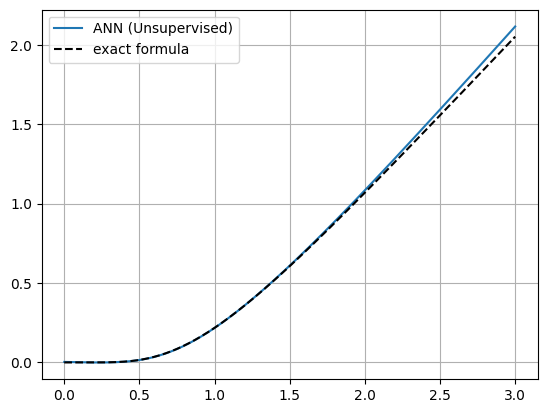

In [78]:
plt.plot(x,u.detach().numpy(),label='ANN (Unsupervised)')
plt.plot(x,price_formula,'--',c='black',label='exact formula')
plt.legend()
plt.grid()

### European Basket Call Option - Uncorrelated Assets

\\[\frac{\partial u}{\partial t} - \frac{1}{2}\sigma_1^2 x^2_1 \frac{\partial^2 u}{\partial x^2_1}
- \frac{1}{2}\sigma_2^2 x^2_2 \frac{\partial^2 u}{\partial x^2_2}- r\left(x_1\frac{\partial u}{\partial x_1}+
x_2\frac{\partial u}{\partial x_2}\right)+ru=0\\]

\\[u(x,0)= \left(\frac{1}{2}\sum_{i=1}^2 x_i-1\right)^+\\]
